In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
# import tensorflow_hub as hub
from datetime import datetime
import time
import pickle
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.utils import shuffle
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l1
from tensorflow.keras import backend
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,Input,BatchNormalization,GlobalMaxPooling1D,GRU,LSTM,Activation,Bidirectional,TimeDistributed,Reshape
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Embedding,Dropout,SpatialDropout1D,Flatten,LeakyReLU,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K

from tqdm import tqdm, trange

Using TensorFlow backend.


In [3]:
# read = lambda imname: np.asarray(Image.open(imname).convert(""))
read = lambda imname: mpimg.imread(imname)

In [13]:
folder_benign_train = 'train/benign/'
folder_malignant_train = 'train/malignant/'

folder_benign_test = 'test/benign/'
folder_malignant_test = 'test/malignant/'

In [15]:
os.listdir(folder_benign_train)

['189.jpg',
 '77.jpg',
 '837.jpg',
 '1353.jpg',
 '1435.jpg',
 '1421.jpg',
 '1347.jpg',
 '638.jpg',
 '1390.jpg',
 '604.jpg',
 '162.jpg',
 '176.jpg',
 '610.jpg',
 '1384.jpg',
 '1179.jpg',
 '1145.jpg',
 '1623.jpg',
 '360.jpg',
 '406.jpg',
 '1192.jpg',
 '1186.jpg',
 '412.jpg',
 '374.jpg',
 '599.jpg',
 '1743.jpg',
 '1031.jpg',
 '228.jpg',
 '214.jpg',
 '1780.jpg',
 '1794.jpg',
 '200.jpg',
 '957.jpg',
 '1569.jpg',
 '1227.jpg',
 '1541.jpg',
 '1555.jpg',
 '1233.jpg',
 '994.jpg',
 '980.jpg',
 '1582.jpg',
 '1596.jpg',
 '764.jpg',
 '1597.jpg',
 '765.jpg',
 '771.jpg',
 '1583.jpg',
 '981.jpg',
 '759.jpg',
 '995.jpg',
 '1554.jpg',
 '1232.jpg',
 '1540.jpg',
 '1568.jpg',
 '942.jpg',
 '956.jpg',
 '567.jpg',
 '201.jpg',
 '1795.jpg',
 '1781.jpg',
 '229.jpg',
 '1030.jpg',
 '1742.jpg',
 '1024.jpg',
 '598.jpg',
 '413.jpg',
 '1187.jpg',
 '375.jpg',
 '361.jpg',
 '1193.jpg',
 '349.jpg',
 '1144.jpg',
 '1622.jpg',
 '1636.jpg',
 '1150.jpg',
 '1178.jpg',
 '177.jpg',
 '1385.jpg',
 '611.jpg',
 '89.jpg',
 '605.jpg',
 

In [16]:
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]

In [17]:
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

In [18]:
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


In [61]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


In [62]:
X_train,y_train = shuffle(X_train,y_train)

In [63]:
X_test,y_test = shuffle(X_test,y_test)

In [64]:
y_train

array([1., 0., 1., ..., 0., 0., 1.])

for generating train and test dataset, I reffered https://www.kaggle.com/fanconic/cnn-for-skin-cancer-detection

<Figure size 360x3600 with 0 Axes>

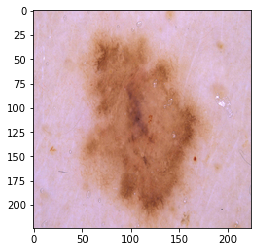

<Figure size 360x3600 with 0 Axes>

In [65]:
plt.imshow(X_train[y_train==0][np.random.randint(0,10),:,:])
plt.figure(figsize=(5,50))

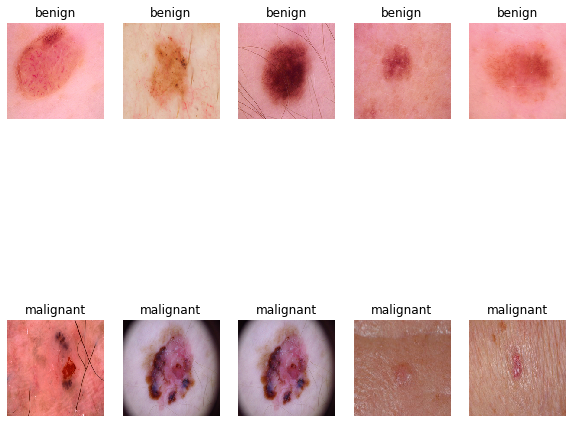

In [66]:
cols = 5
num_classes = 2
fig,axs = plt.subplots(nrows = num_classes,ncols = cols,figsize = (10,10))
for i in range(num_classes):
    for j in range(cols):
        if i == 0:
            axs[i][j].set_title("benign")
        else:
            axs[i][j].set_title("malignant")
        x_selected = X_train[y_train==i]
        axs[i][j].imshow(x_selected[np.random.randint(0,10),:,:])
        axs[i][j].axis("off")

In [67]:
def grayScale(img):
    #this function reduce dimentionality of dataset from RGB(3d) to gray(1D)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

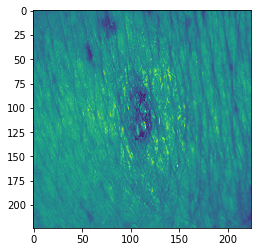

In [68]:
img = grayScale(X_train[10])
plt.imshow(img)

In [69]:
def equalizationOfImage(img):
#this func will equalize image which means the brightness of image is flattened
    return cv2.equalizeHist(img)

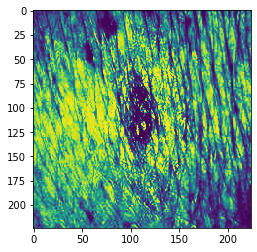

In [70]:
img = equalizationOfImage(img)
plt.imshow(img)

In [71]:
def imgPreprocessing(img):
    
    img = grayScale(img)
    img = equalizationOfImage(img)
    img = img/255
    #here normalize the scale of images between 0 and 1
    return img

In [72]:
X_train1 = np.array(list(map(imgPreprocessing,X_train)))
X_test1 = np.array(list(map(imgPreprocessing,X_test)))

In [73]:
X_train1[100].shape

(224, 224)

In [74]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],X_train1.shape[2],1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1],X_test1.shape[2],1)

In [76]:
X_train1.shape

(2637, 224, 224, 1)

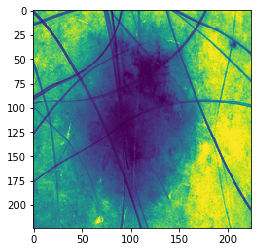

In [83]:
plt.imshow(X_train1[100].reshape(X_train1[100].shape[0],X_train1[100].shape[1]))

# Normal CNN

In [84]:
X_train2 = X_train1.copy()
X_test2 = X_test1.copy()

In [85]:
X_train2,X_validation2,y_train2,y_validation2 = train_test_split(X_train2,y_train,test_size=0.2,random_state=42)

In [86]:
X_train2.shape

(2109, 224, 224, 1)

In [87]:
def building_model():
    model = Sequential()
    model.add(Conv2D(32,(5, 5),input_shape=X_train2.shape[1:],activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(Conv2D(32,(5,5), activation = 'relu',kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(5,5),activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(Conv2D(64,(5,5),activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,(3,3),activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(Conv2D(128,(3,3),activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation="relu",kernel_initializer = "RandomNormal",bias_initializer="zeros"))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer=Adam(lr=0.001),metrics=["accuracy"])
    return model

In [88]:
model = building_model()

In [89]:
filepath="model/model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True, mode='max')
callbackList = [checkpoint]

In [ ]:
history = model.fit(X_train2,y_train2,validation_data=(X_validation2,y_validation2),batch_size=210,epochs = 50,callbacks=callbackList)

Train on 2109 samples, validate on 528 samples
Epoch 1/50


# CNN with X_train = X_train + generated image data 

In [ ]:
generator = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=30,horizontal_flip=True,vertical_flip=True)

In [ ]:
generator.fit(X_train2)

In [ ]:
for X_batch, y_batch in generator.flow(X_train2, y_train2, batch_size=9):
    print(y_batch[5])
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(224,224))
    plt.show()
    break

In [ ]:
param = {
    'theta':30,
    'shear':30,
    'flip_vertical':True,
    'flip_horizontal':True
}

In [ ]:
generated_img = np.array([generator.apply_transform(x,param) for x in X_train2])

In [ ]:
generated_img.shape

In [ ]:
plt.imshow(X_train2[1].reshape(224,224))

In [ ]:
plt.imshow(generated_img[1].reshape(224,224))

In [ ]:
X_train3 = np.concatenate([X_train2,generated_img])

In [ ]:
X_train3.shape

In [ ]:
y_train3 = np.concatenate([y_train2,y_train2])
y_train3.shape

In [ ]:
X_train3,y_train3 = shuffle(X_train3,y_train3)

In [ ]:
model = building_model()
filepath="model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True, mode='max')
callbackList = [checkpoint]

In [ ]:
model.fit(X_train3,y_train3,
          validation_data=(X_validation2,y_validation2),batch_size=210,epochs = 20,callbacks=callbackList,shuffle=True)


# CNN with ImageDataGenerator

In [ ]:
X_validation1 = np.array([generator.apply_transform(x,param) for x in X_validation2])

In [ ]:
X_validation1.shape

In [ ]:
model_gen = building_model()

In [ ]:
filepath="model_gen.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True, mode='max')
callbackList = [checkpoint]

In [ ]:
history = model_gen.fit_generator(generator.flow(X_train2,y_train2),validation_data=(X_validation1,y_validation2),
                                  steps_per_epoch=X_train1.shape[0]/50,epochs = 50,callbacks=callbackList)


# GAN

In [ ]:
def make_descriminator(inputShape=(224,224,1)):
    model = Sequential()
    model.add(Conv2D(32,(5, 5),padding="same",input_shape=inputShape))
    model.add(LeakyReLU())
    model.add(Conv2D(64,(5,5)))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3)))
    model.add(LeakyReLU())
    model.add(Conv2D(128,(3,3)))
    model.add(LeakyReLU())
#     model.add(GlobalAvgPool2D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

    return model

In [ ]:
def make_generator():
    model = Sequential()
    model.add(Dense(128*28*28,input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((28,28,128)))
#     assert model.output_shape == (None, 28, 28, 128)
    model.add(Conv2DTranspose(64,(4,4),padding="same",strides=(2,2)))
#     assert model.output_shape == (None, 56, 56, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(32,(4,4),padding="same",strides=(2,2)))
#     assert model.output_shape == (None, 112, 112, 32)
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1,(4,4),activation="tanh",strides=(2,2),padding="same"))
#     assert model.output_shape == (None, 223, 224, 1)
    return model
    
              

In [ ]:
generator = make_generator()
noise = tf.random.normal([1,100])
generated_img = generator(noise,training=False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = make_descriminator()
decision = discriminator(generated_img)
print(decision)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output,y_real,fake_output,y_fake):
    real_loss = cross_entropy(y_real,real_output)
    fake_loss = cross_entropy(y_fake, fake_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
noise_dim = 100
num_examples_to_generate = 8

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_fake_images(generator,noise,n_samples):
    generated_images = generator(noise,training=True)
    y = np.zeros((n_samples,1))
    return generated_images,y

In [ ]:
def generate_real_images(real_images,labels,n_samples):
#     real_images,labels = dataset
    ix = np.random.randint(0,real_images.shape[0],n_samples)
    X,labels = real_images[ix],labels[ix]
    
    return X,labels

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    z_input = np.random.randn(latent_dim * n_samples)
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
def train(X_train,y_train,noise_dim,epochs,n_batches = 100):
    
    batch_per_epochs = int(X_train.shape[0]/n_batches)
    n_steps = batch_per_epochs * epochs
    half_batch = int(n_batches / 2)
    
    for i in range(n_steps):
        noise = tf.random.normal([half_batch, noise_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            X_real,y_real = generate_real_images(X_train,y_train,half_batch)
    #         d_loss,d_acc = d_model.train_on_batch(X_real,y_real)
            real_output = discriminator(X_real,training=True)
            X_fake,y_fake = generate_fake_images(generator,noise,half_batch)
            fake_output = discriminator(X_fake,training=True)
            
            d_loss = discriminator_loss(real_output,y_real,fake_output,y_fake)
            g_loss = generator_loss(fake_output)
            
            gradient_of_gen = gen_tape.gradient(g_loss,generator.trainable_variables)
            gradient_of_dis = disc_tape.gradient(d_loss,discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradient_of_gen,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradient_of_dis,discriminator.trainable_variables))
            

#             X_gan,y_gan = generate_latent_points(100,n_batches),np.ones((n_batches,1))
#             g_loss = gan_model.train_on_batch(X_gan,y_gan)

        if (i+1) % (batch_per_epochs * 1) == 0:
            print('>%d, c[%.3f], g[%.3f]' % (i+1, d_loss, g_loss))


In [ ]:
X_train4 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],X_train1.shape[2],1)
X_test4 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1],X_test1.shape[2],1)
y_train4 = y_train.copy()
y_test4 = y_test.copy()

In [ ]:
print(X_train4.shape)
print(y_train.shape)

In [ ]:
noise_DIM = 100
EPOCHS = 50

In [ ]:
train(X_train=X_train4,y_train=y_train4,noise_dim=noise_DIM,epochs=EPOCHS)

In [ ]:
y_test1 = y_test.reshape(y_test.shape[0],1)
y_test1.shape

In [ ]:
print(X_test4.shape)
print(y_test4.shape)

In [ ]:
discriminator.evaluate(X_test4,y_test)